In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os, glob
!pip install pydicom
import pydicom
import pylab as pl
import sys
import matplotlib.path as mplPath
import matplotlib.patches as patches
from matplotlib import pyplot as plt
from matplotlib import cm
from tensorflow.keras.utils import Sequence


In [27]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [28]:
print ('Files in Drive:')
!ls /content/drive/

Files in Drive:
'My Drive'


In [29]:
!git clone https://github.com/rashmi43/PneumoniaDetector

Cloning into 'PneumoniaDetector'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 5712 (delta 1), reused 4 (delta 0), pack-reused 5705
Receiving objects: 100% (5712/5712), 81.64 MiB | 16.98 MiB/s, done.
Resolving deltas: 100% (893/893), done.
Checking out files: 100% (315/315), done.


In [0]:
#Set your project path 
project_path = '/content/drive/My Drive/Colab Notebooks/CAPSTONE'
os.chdir(project_path)

In [31]:
print ('Files in Drive:')
!ls /content/drive/My\ Drive/Colab\ Notebooks/CAPSTONE

Files in Drive:
PneumoniaDetection.ipynb	 stage_2_train_images
PneumoniaDetector		 stage_2_train_labels.csv
stage_2_detailed_class_info.csv


In [32]:
df=pydicom.read_file("./stage_2_train_images/0a0f6755-610d-4b7c-a460-5f5a8f5c0743.dcm")
df.pixel_array

array([[  1,   1,   2, ...,   5,   5,   3],
       [  1,   1,   2, ...,   8,   8,   6],
       [  2,   1,   1, ...,   9,   8,   6],
       ...,
       [  0,   1,   1, ..., 212, 216, 119],
       [  0,   4,   0, ..., 220, 223, 136],
       [  2,   2,   0, ...,  97, 117,  60]], dtype=uint8)

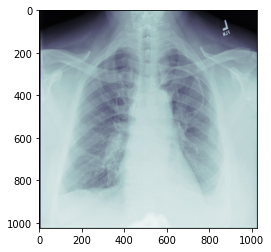

In [33]:
import matplotlib.pyplot as plt
import pydicom
filename = './stage_2_train_images/0a0f6755-610d-4b7c-a460-5f5a8f5c0743.dcm'
ds = pydicom.dcmread(filename)
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)


Filename.........: ./stage_2_train_images/0a0f6755-610d-4b7c-a460-5f5a8f5c0743.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name...: 0a0f6755-610d-4b7c-a460-5f5a8f5c0743, 
Patient id.......: 0a0f6755-610d-4b7c-a460-5f5a8f5c0743
Modality.........: CR
Study Date.......: 19010101
Image size.......: 1024 x 1024, 97240 bytes
Pixel spacing....: [0.168, 0.168]
Slice location...: (missing)


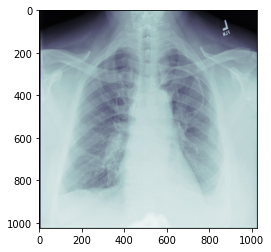

In [34]:
dataset = pydicom.dcmread(filename)

# Normal mode:
print()
print("Filename.........:", filename)
print("Storage type.....:", dataset.SOPClassUID)
print()

pat_name = dataset.PatientName
display_name = pat_name.family_name + ", " + pat_name.given_name
print("Patient's name...:", display_name)
print("Patient id.......:", dataset.PatientID)
print("Modality.........:", dataset.Modality)
print("Study Date.......:", dataset.StudyDate)

if 'PixelData' in dataset:
    rows = int(dataset.Rows)
    cols = int(dataset.Columns)
    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
        rows=rows, cols=cols, size=len(dataset.PixelData)))
    if 'PixelSpacing' in dataset:
        print("Pixel spacing....:", dataset.PixelSpacing)

# use .get() if not sure the item exists, and want a default value if missing
print("Slice location...:", dataset.get('SliceLocation', "(missing)"))

# plot the image using matplotlib
plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.show()

In [0]:
train_labels = pd.read_csv('./stage_2_train_labels.csv')

In [36]:
print(train_labels.shape)
print(train_labels.head())

(30227, 6)
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1


In [37]:
print(train_labels['Target'].value_counts())

0    20672
1     9555
Name: Target, dtype: int64


9555 patients have some type of lung opacities in their xrays.

In [50]:
train_labels['patientId'].value_counts()

1bf08f3b-a273-4f51-bafa-b55ada2c23b5    4
0d5bc737-03de-4bb8-98a1-45b7180c3e0f    4
8dc8e54b-5b05-4dac-80b9-fa48878621e2    4
31764d54-ea3b-434f-bae2-8c579ed13799    4
0ab261f9-4eb5-42ab-a9a5-e918904d6356    4
                                       ..
098cc073-48f8-4cb9-b6fc-4b2cc5d8e081    1
ceea22bd-493f-4d24-a49d-e13d70b3a01d    1
e77f1166-ed2e-4cc2-820f-c5c0e3a50abb    1
fb533c87-6972-43e0-9a98-0144c900246f    1
de54e3a7-5942-4fa9-941f-f147a26643e0    1
Name: patientId, Length: 26684, dtype: int64

As you can see some patients have more than 1 lung opacities. Hence, there is more than 1 entry for patients with lung problems.


In [39]:
train_labels[train_labels['patientId'] == '00436515-870c-4b36-a041-de91049b9ab4']

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [40]:
df = pd.read_csv('./stage_2_detailed_class_info.csv')
df.shape

(30227, 2)

In [41]:
df.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [42]:
result = pd.concat([df, train_labels], axis=1, sort=False)
result.head()

,patientId,class,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [43]:
df[df['patientId'] == '0a0f91dc-6015-4342-b809-d19610854a21']

,patientId,class
757,0a0f91dc-6015-4342-b809-d19610854a21,Lung Opacity


In [44]:
name = '0a0f91dc-6015-4342-b809-d19610854a21'
if (df[df['patientId'] == name]['class'].values == 'Lung Opacity'):
    print(True)

True


In [45]:
df['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

There are 11821 cases who have a lung condition but its not pneumonia
There are 9555 cases who have lung opacity related to pneumonia
There are 8851 cases which not have any lung opacities

In [46]:
#directory = '../stage_2_train_images'
directory = os.path.join('/','content','drive', 'My Drive', 'Colab Notebooks','CAPSTONE','stage_2_train_images')
files_dir = os.listdir(directory)
print(len(files_dir))
images = []
i = 0
for names in files_dir:
    name = names.split('.')[0]
    if (df[df['patientId'] == name]['class'].values == 'Lung Opacity').any():
        print(names)
        images.append('./stage_2_train_images/'+names)
        i = i + 1
    if (i>10):
        break

print(images)

17680
49f0fa25-89cd-41a7-9c70-4d7d8d9be572.dcm
784a3ed0-2565-430f-819f-f713e1775344.dcm
0a825a59-c034-481c-b596-9c7f0bc42c2c.dcm
383e9756-7d45-4289-b35a-9fb2a5108e81.dcm
7fb3c5d0-81fd-46e3-9063-cd8d71831790.dcm
74ed4f73-33e6-4607-8842-57aec6c318c6.dcm
a410dbbd-1ee8-4b79-876e-200b093b0e43.dcm
b9a014f0-6ab0-449a-be4d-1911473dde10.dcm
3730cf87-f147-4872-8885-44700d3eacaf.dcm
0bbb1ff7-dba6-4d5b-affe-b3ca0050d965.dcm
6efd348c-705e-4e83-bbd1-97e336ee6b1e.dcm
['./stage_2_train_images/49f0fa25-89cd-41a7-9c70-4d7d8d9be572.dcm', './stage_2_train_images/784a3ed0-2565-430f-819f-f713e1775344.dcm', './stage_2_train_images/0a825a59-c034-481c-b596-9c7f0bc42c2c.dcm', './stage_2_train_images/383e9756-7d45-4289-b35a-9fb2a5108e81.dcm', './stage_2_train_images/7fb3c5d0-81fd-46e3-9063-cd8d71831790.dcm', './stage_2_train_images/74ed4f73-33e6-4607-8842-57aec6c318c6.dcm', './stage_2_train_images/a410dbbd-1ee8-4b79-876e-200b093b0e43.dcm', './stage_2_train_images/b9a014f0-6ab0-449a-be4d-1911473dde10.dcm', './sta

In [0]:
def show_images(images: list) -> None:
    n: int = len(images)
    f = plt.figure(figsize=(16, 16))
    for i in range(n+1):
        # Debug, plot figure
        f.add_subplot(5, 2, i+1)
        dataset = pydicom.dcmread(images[i])
        plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)

    plt.show(block=True)

ValueError: ignored

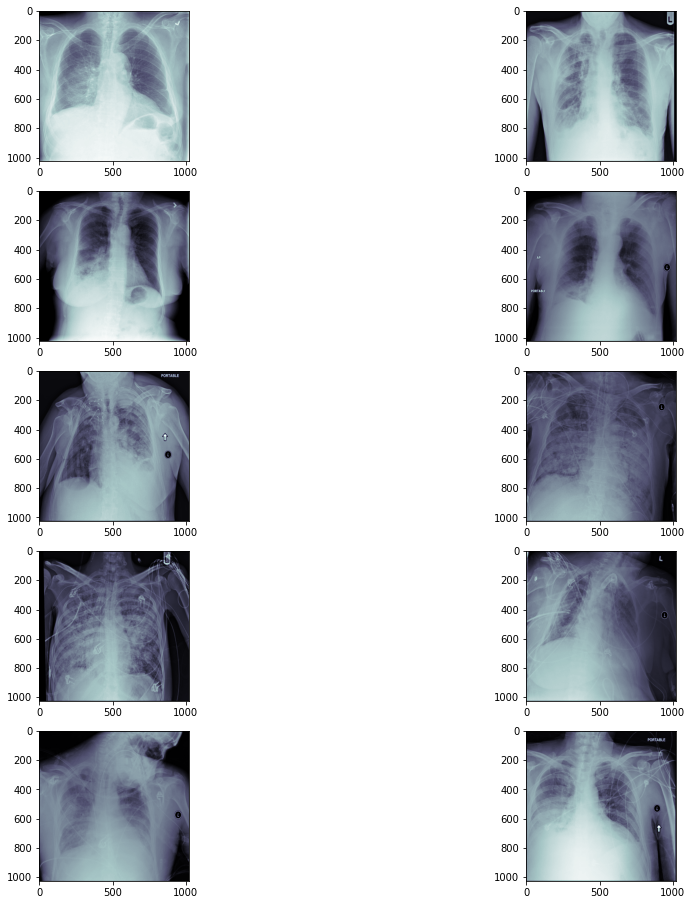

In [48]:
show_images(images)

In [0]:
filename = './stage_2_train_images/0a0f6755-610d-4b7c-a460-5f5a8f5c0743.dcm'
ds = pydicom.dcmread(filename)
#plt.imshow(ds.pixel_array, cmap=plt.cm.bone)

fig,ax = plt.subplots(1)

# Display the image
ax.imshow(ds.pixel_array)
x = 264.0	
y = 152.0	
h = 213.0	
w = 379.0	
# Create a Rectangle patch
rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
plt.show()


In [0]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
    # Do not include classification (top) layer

    # to freeze layers, except the new top layer, of course, which will be added below
    for layer in model.layers:
        layer.trainable = trainable

    # Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
    x = model.layers[-1].output
    x = Conv2D(4, kernel_size=4, name="coords")(x)
    # In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
    x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

    return Model(inputs=model.input, outputs=x)

In [0]:
def draw_rectangle_opacity(filename, x, y, w, h):
    try:
        ds = pydicom.dcmread(filename)
    except:
      print('File Not Found'+ filename)
      return
    if type(x) is str:
        x = float(x)
    if type(y) is str:
        y = float(y)
    if type(w) is str:
        w = float(w)
    if type(h) is str:
        h = float(h)
    fig,ax = plt.subplots(1)
    # Display the image
    ax.imshow(ds.pixel_array)
    # Create a Rectangle patch
    print(x, y, w, h)
    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.title(filename)
    plt.show()

In [0]:
# Training Data Generator

class DataSequence(Sequence):

    def __init__(self, csv_file):
            with open('./stage_2_train_labels.csv', "r") as file:
                self.details = np.zeros((sum(1 for line in file), 6))
                file.seek(0)

                reader = csv.reader(file, delimiter=",") # Read CSV file
                for index, row in enumerate(reader):
                    if (index == 0):
                        continue;
                    if (index == 30):
                      break;
                    patientId, x, y, w, h, target = row
                    if (x == '' or y == '' or w == '' or h == ''):
                        x = y = w = h = 0
                    if (x != '' and y != '' and w != '' and h != ''):
                        draw_rectangle_opacity('./stage_2_train_images/'+patientId+'.dcm', x, y, w, h)
                    #self.details[index, 0] = patientId # add patientId
                    self.details[index, 1] = float(x) # Normalize bounding box by image size
                    self.details[index, 2] = float(y )# Normalize bounding box by image size
                    self.details[index, 3] = float(w)
                    self.details[index, 4] = float(h) # Normalize bounding box by image size
                    self.details[index, 5] = int(target)
                    #print(self.details[index])
                    

0 0 0 0


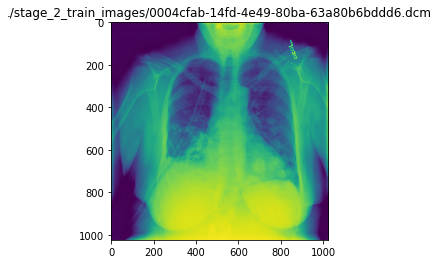

File Not Found./stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm
0 0 0 0


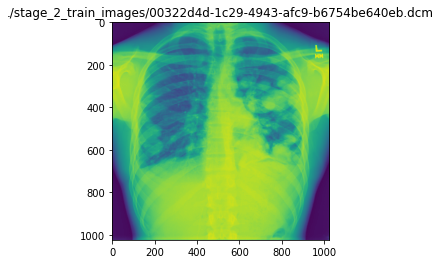

0 0 0 0


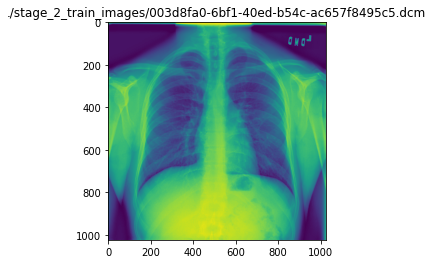

264.0 152.0 213.0 379.0


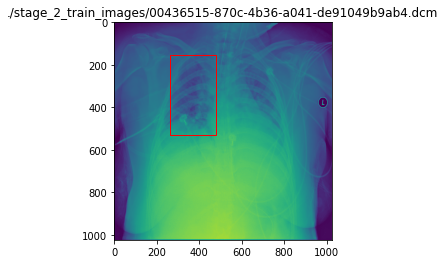

562.0 152.0 256.0 453.0


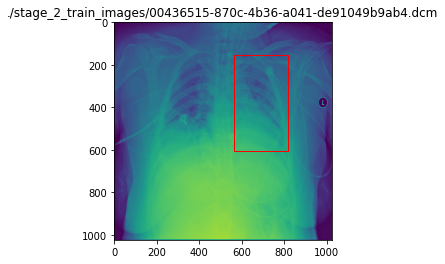

File Not Found./stage_2_train_images/00569f44-917d-4c86-a842-81832af98c30.dcm
0 0 0 0


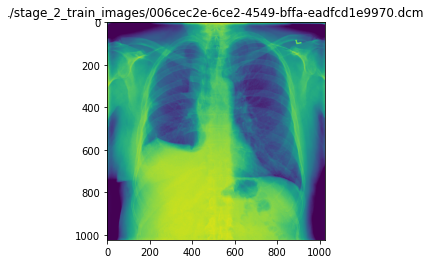

323.0 577.0 160.0 104.0


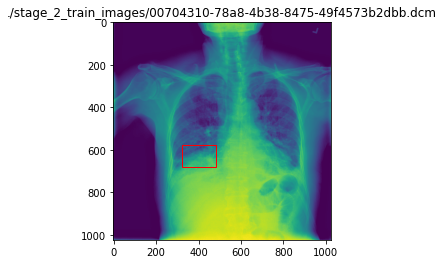

695.0 575.0 162.0 137.0


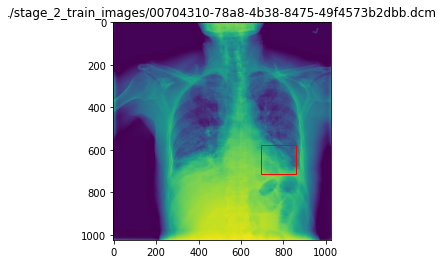

0 0 0 0


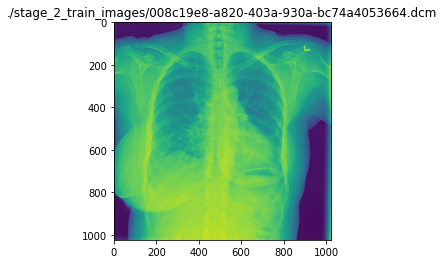

0 0 0 0


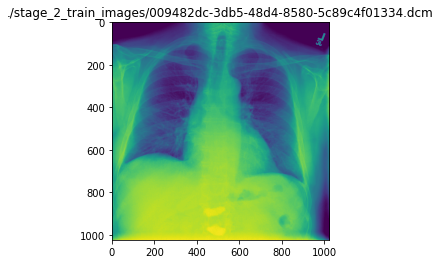

File Not Found./stage_2_train_images/009eb222-eabc-4150-8121-d5a6d06b8ebf.dcm
0 0 0 0


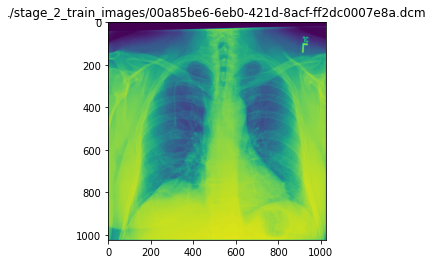

288.0 322.0 94.0 135.0


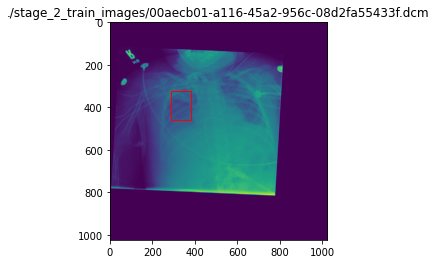

547.0 299.0 119.0 165.0


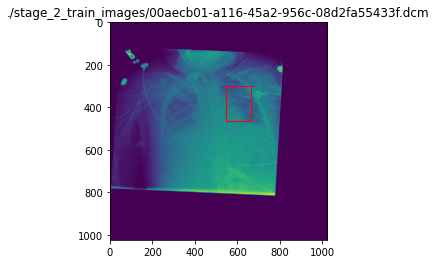

306.0 544.0 168.0 244.0


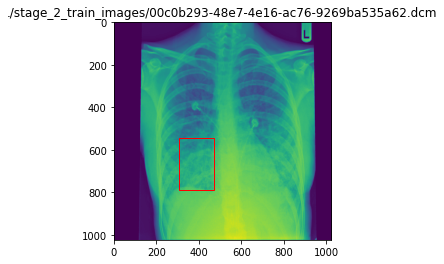

650.0 511.0 206.0 284.0


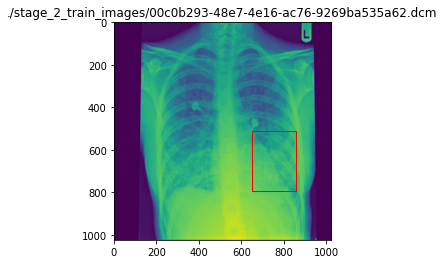

File Not Found./stage_2_train_images/00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b.dcm
181.0 184.0 206.0 506.0


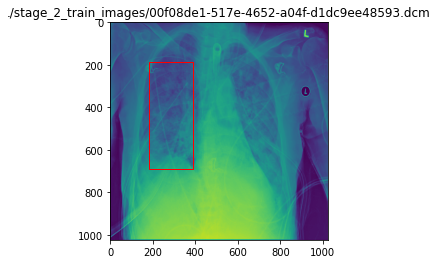

571.0 275.0 230.0 476.0


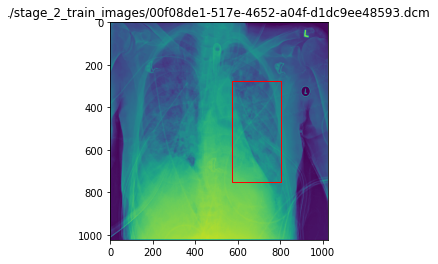

0 0 0 0


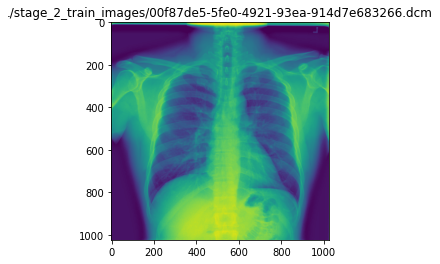

File Not Found./stage_2_train_images/0100515c-5204-4f31-98e0-f35e4b00004a.dcm
File Not Found./stage_2_train_images/01027bc3-dc40-4165-a6c3-d6be2cb7ca34.dcm
652.0 437.0 161.0 293.0


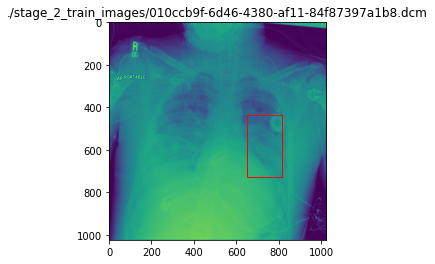

301.0 405.0 141.0 279.0


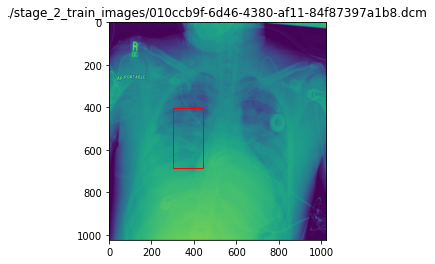

0 0 0 0


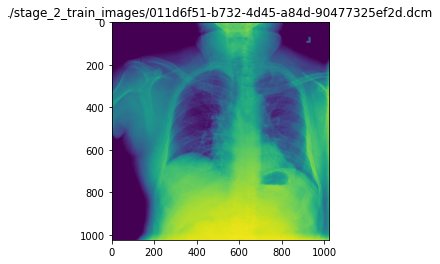

133.0 613.0 275.0 275.0


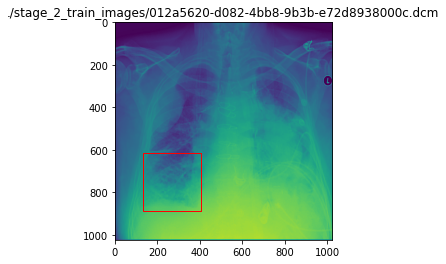

678.0 427.0 224.0 340.0


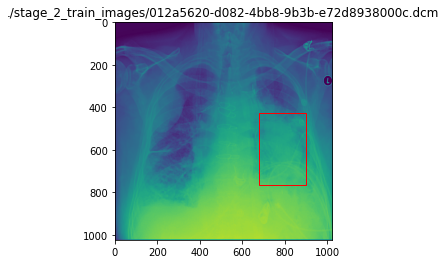

In [108]:
TRAIN_CSV = './stage_2_train_labels.csv'
train_datagen = DataSequence(TRAIN_CSV) # Generate training data batches